# Out-of-distribution detection with Plex
> A demo on detecting Out of Distribution data points with Google Plex

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/hist_plot.png

> twitter: https://twitter.com/GoogleAI/status/1547639839650000896

This notebook demonstrates how one can utilize the released checkpoints from the *Plex: Towards Reliability using Pretrained Large Model Extensions* paper which are using [JAX](https://jax.readthedocs.io/) and [Tensorflow](https://www.tensorflow.org/) as backends. The demo showcases basic mechanics for loading and using the pretrained Plex model checkpoints, as well as more advanced usecases like zero-shot out-of-distribution detection. The **General usage** section provides a minimal setup for loading the checkpoints. Plex is designed to excel in three areas of reliability, ***Uncertainty***, ***Robust Generalization***, and ***Adaptation***. Here, we focus at the ***Adaptation*** aspect of pretrained models by demonstrating zero-shot out-of-distribution (OOD) detection.

## Imports

Broadly speaking, Plex is a set of pre-trained large model extensions that can be applied to many different architectures like the current state-of-the-art Vision Transformers and T5 models. For our demonstration, we will be loading the pretrained ViT-Plex Large model, that was pretrained on ImageNet-21K, using [JAX](https://jax.readthedocs.io/) backend. Check out the paper [here](https://arxiv.org/pdf/2207.07411.pdf) and the open-sourced implementation [here](https://github.com/google/uncertainty-baselines/tree/main/experimental/plex).

In [ ]:
#collapse-output
import functools
from clu import preprocess_spec
import flax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import ml_collections
import sklearn
import tensorflow as tf
import tensorflow_datasets as tfds
import uncertainty_baselines as ub
import checkpoint_utils  # local file import from Plex repository
import input_utils  # local file import from Plex repository
import preprocess_utils  # local file import from Plex repository

/home/users/yugam/anaconda3/envs/drpy9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Traceback (most recent call last):
  File "/home/users/yugam/uncertainty-baselines/uncertainty_baselines/datasets/datasets.py", line 60, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/home/users/yugam/uncertainty-baselines/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 'seqio'
Traceback (most recent call last):
  File "/home/users/yugam/uncertainty-baselines/uncertainty_baselines/datasets/__init__.py", line 71, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/home/users/yugam/unc

In order to generate pseudorandom numbers, JAX differs from NumPy and requires an explicit PRNG (pseudorandom number generators) state to be passed as a first argument. For reasons, check [this](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/05-random-numbers.ipynb#scrollTo=JGCZI9UTl7o4).

In [ ]:
#collapse-output
# Set a base seed to use for the notebook.
rng = jax.random.PRNGKey(42)

print(jax.local_devices())

2022-09-14 15:22:53.573404: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/users/yugam/anaconda3/envs/drpy9/lib/
2022-09-14 15:22:53.573448: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


[CpuDevice(id=0)]


## General Usage

### Load Pretrained ViT-Plex model

A key feature of Plex is more efficient ensembling based on submodels that each make a prediction that is then aggregated. In addition, Plex swaps each architecture’s linear last layer with a [Gaussian process](https://arxiv.org/abs/2006.10108) or [heteroscedastic layer](https://arxiv.org/abs/2105.10305) to better represent predictive uncertainty. These ideas were found to work very well for models trained from scratch at the ImageNet scale. The models are trained with varying sizes up to 325 million parameters for vision (ViT-Plex L) and 1 billion parameters for language (T5-Plex L) and pre-training dataset sizes up to 4 billion examples. For our demo, we will be using the [ViT](https://arxiv.org/abs/2010.11929) architecture with the [Batch Ensemble](https://arxiv.org/abs/2002.06715) layers. To specify the layers, we can define the config file as follows:

In [ ]:
def get_pretrained_config():
  # From `https://github.com/google/uncertainty-baselines/blob/main/baselines/jft/experiments/vit_be/imagenet21k_be_vit_large_32.py`.
  config = ml_collections.ConfigDict()
  config.model = ml_collections.ConfigDict()
  config.model.patches = ml_collections.ConfigDict()
  config.model.patches.size = [32, 32]
  config.model.hidden_size = 1024
  config.model.transformer = ml_collections.ConfigDict()
  config.model.transformer.mlp_dim = 4096
  config.model.transformer.num_heads = 16
  config.model.transformer.num_layers = 24
  config.model.transformer.attention_dropout_rate = 0.
  config.model.transformer.dropout_rate = 0.1
  config.model.classifier = 'token'
  config.model.representation_size = 1024

  # BatchEnsemble
  config.model.transformer.be_layers = (21, 22, 23)
  config.model.transformer.ens_size = 3
  config.model.transformer.random_sign_init = -0.5
  config.model.transformer.ensemble_attention = False

  return config

In [ ]:
#collapse-output
num_classes = 21843 # Total number of classes in ImageNet-21k
config = get_pretrained_config()
model = ub.models.vision_transformer_be(
    num_classes=num_classes, **config.model)

/home/users/yugam/anaconda3/envs/drpy9/lib/python3.9/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
Traceback (most recent call last):
  File "/home/users/yugam/uncertainty-baselines/uncertainty_baselines/models/__init__.py", line 105, in <module>
    from uncertainty_baselines.models import bert
  File "/home/users/yugam/uncertainty-baselines/uncertainty_baselines/models/bert.py", line 30, in <module>
    from official.nlp.bert import bert_models
ModuleNotFoundError: No module named 'official.nlp.bert'


In [ ]:
#collapse-output
checkpoint_path = 'gs://plex-paper/plex_vit_large_imagenet21k.npz'

read_in_parallel = False
checkpoint = checkpoint_utils.load_checkpoint(None, path=checkpoint_path,
                                              read_in_parallel=read_in_parallel)
pretrained_params = checkpoint["opt"]["target"]

2022-09-14 15:23:03.436479: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


## Zero-shot out-of-distribution detection

Here we demonstrate zero-shot out-of-distribution (OOD) detection using the upstream pretrained model and the **Relative Mahalanobis distance** metric ([Ren et al., 2021](http://arxiv.org/abs/2106.09022)). In zero-shot OOD detection, the goal is to take a fixed model that was pretrained on dataset A and use it to distinguish between in-distributions samples from dataset B and OOD sample from dataset C, all without fine-tuning the model further on datset B or C. We see that pretrained Plex without any finetuning is able to achieve a strong separation between in and out of distribution.

### Extracting embeddings/representations from the pretrained model

In [ ]:
@jax.jit
def representation_fn(params, images, rng):
    rng_dropout, rng_diag_noise, rng_standard_noise = jax.random.split(rng, num=3)
    _, out = model.apply(
      {'params': flax.core.freeze(params)},
      images,
      train=False,
      rngs={
          'dropout': rng_dropout,
          'diag_noise_samples': rng_diag_noise,
          'standard_norm_noise_samples': rng_standard_noise})
    representations = out["pre_logits"]
    ens_representations = jnp.stack(jnp.split(representations,
                                            model.transformer.ens_size), axis=1)
    return ens_representations  # Shape (batch_size, ens_sizen, um_classes).

We require a model function that can work across multiple TPU devices or across
multiple GPUs for high performance. 

In [ ]:
pmapped_representation_fn = jax.pmap(representation_fn, in_axes=(None, 0, None))

The value for `in_axes` means that the `params` argument for `representation_fn` will be copied to each device, the `images` will be split ("sharded") across the devices along the first axis, and the `rng` will be copied to each device. Note that this means that `images` should have shape `(num_devices, batch_size, h, w, c)` so that each device processes a `(batch_size, h, w, c)` chunk of the images. The `params` and `rng` will be the same across all the devices.

### Load In Distribution Dataset


For our In Distribution Dataset, we will be using the open-sourced [Imagenet_v2](https://www.tensorflow.org/datasets/catalog/imagenet_v2) dataset which mainly contains new test data for the ImageNet benchmark.

In [ ]:
def load_val_ds(dataset, split, batch_size, preprocess_eval_fn):
    val_ds = input_utils.get_data(
      dataset=dataset,
      split=split,
      rng=None,
      process_batch_size=batch_size,
      preprocess_fn=preprocess_eval_fn,
      cache=False,
      num_epochs=1,
      repeat_after_batching=True,
      shuffle=False,
      prefetch_size=0,
      drop_remainder=False,
      data_dir=None)
    return val_ds

  The data loader yields examples of shape (num_devices, batch_size, ...), that is, it splits the batch_size across the number of local devices, under the assumption that TPUs or multiple GPUs are used.

In [ ]:
#collapse-output
dataset = "imagenet_v2"
tfds.builder(dataset).download_and_prepare()
batch_size = 64 * jax.local_device_count()
split = "test"
in_ds, in_ds_info = tfds.load(dataset, split=split, with_info=True)

pp_eval = f"decode|resize_small(256)|central_crop(224)|value_range(-1, 1)|onehot(1000, key='label', key_result='labels')|keep(['image', 'labels'])"
preprocess_eval_fn = preprocess_spec.parse(
    spec=pp_eval, available_ops=preprocess_utils.all_ops())

in_val_ds = load_val_ds(dataset, split=split, batch_size=batch_size,
                     preprocess_eval_fn=preprocess_eval_fn)

2022-09-14 15:32:21.365371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/users/yugam/anaconda3/envs/drpy9/lib/
2022-09-14 15:32:21.365436: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


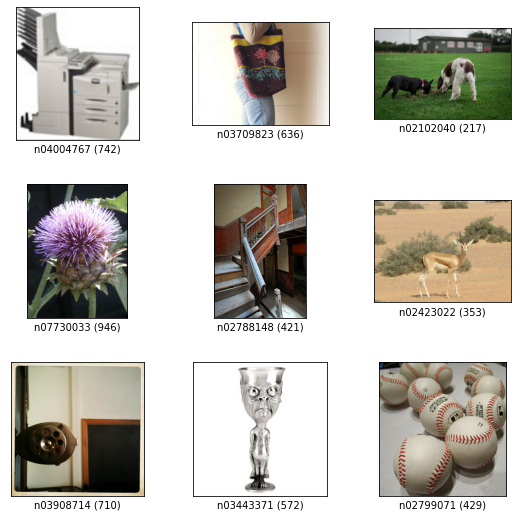

In [ ]:
#collapse-output
fig = tfds.show_examples(in_ds, in_ds_info)

### Load Out of Distribution Dataset

For our Out of Distribution Dataset, we will be using the open-sourced [Fashion_mnist](https://www.tensorflow.org/datasets/catalog/fashion_mnist) dataset which is a dataset of Zalando's article images. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [ ]:
#collapse-output
dataset = "fashion_mnist"
tfds.builder(dataset).download_and_prepare()
batch_size = 64 * jax.local_device_count()
split = "test"
out_ds, out_ds_info = tfds.load(dataset, split=split, with_info=True)

pp_eval = "decode|resize_small(256)|central_crop(224)|value_range(-1, 1)|keep(['image'])"
preprocess_eval_fn = preprocess_spec.parse(
    spec=pp_eval, available_ops=preprocess_utils.all_ops())

out_val_ds = load_val_ds(dataset, split=split, batch_size=batch_size,
                     preprocess_eval_fn=preprocess_eval_fn)

2022-09-14 15:32:25.513154: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


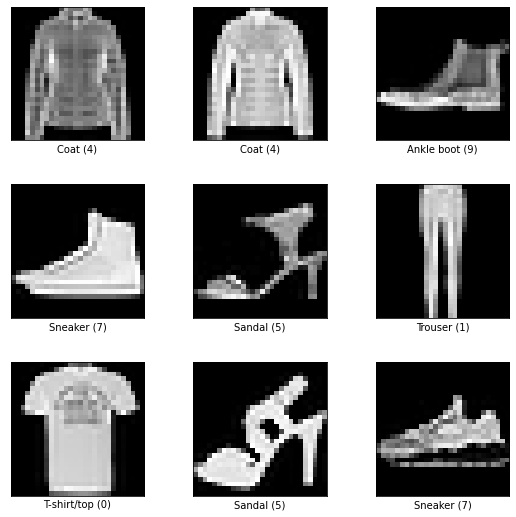

In [ ]:
#collapse-output
fig_out = tfds.show_examples(out_ds, out_ds_info)

### Computing Uncertainty Score : Relative Mahalanobis Distance

Given that the pretrained model itself provides rich
and robust representations, we can use that as a feature extractor and conduct zero-shot
open set recognition without any training examples. To do so, we can take advantage of
Mahalanobis distance (Maha) [Lee et al., 2018](https://arxiv.org/abs/1807.03888) as a detection score: Maha measures the
distance between the test input and the fitted training distribution in the embedding space.
It operates on a fixed representation layer and does not require operating on softmax outputs
with a newly trained last layer. 



The training distribution is fitted using a class conditional
Gaussian $N (µ_k, Σ),\ k = 1, 2, . . . , K
$ to each of the K in-distribution classes based on the
embedding $z$. We estimate the mean vectors and covariance matrix as: $µ_k$ and $Σ$. Note that the class-conditional means $µ_k$ are independent for each class, while the covariance matrix $Σ$ is shared by
all classes to avoid under-fitting errors. For a test input $z$, Mahalanobis distance is calculated as: 
$MD(z) = min_{k} \{ (z - \mu_{k})^{T} \ Σ^{-1} \ (z - \mu_{k})\}$

In order to remove the interference of background distributions, a modified version of Mahalanobis distance which corrects for the background confounding effect using another Gaussian distribution fitted using entire training data , ignoring class labels, is used. This is known as the Relative Mahalanobis Distance and it is calculated as: $RMD(z) = MD(z) - MD_0(z)$ where $MD_0(z)$ indicates the Mahalanobis distance to a distribution fitted to the entire training data not considering the class labels.

In [ ]:
@jax.jit
def compute_mean_and_cov(embeds, labels, class_ids):
    """Computes class-specific means and a shared covariance matrix.

    Args:
    embeds: A jnp.array of size [n_train_sample, n_dim], where n_train_sample is
      the sample size of training set, n_dim is the dimension of the embedding.
    labels: A jnp.array of size [n_train_sample, ].
    class_ids:  A jnp.array of the unique class ids in `labels`.

    Returns:
    means: A list of len n_class, and the i-th element is an np.array of size
      [n_dim, ] corresponding to the mean of the fitted Gaussian distribution
      for the i-th class.
    cov: The shared covariance matrix of the size [n_dim, n_dim].
    """
    n_dim = embeds.shape[1]
    cov = jnp.zeros((n_dim, n_dim))

    def f(cov, class_id):
        mask = jnp.expand_dims(labels == class_id, axis=-1) # to compute mean/variance use only those which belong to current class_id
        data = embeds * mask
        mean = jnp.sum(data, axis=0) / jnp.sum(mask)
        diff = (data - mean) * mask
        cov += jnp.matmul(diff.T, diff)
        return cov, mean

    cov, means = jax.lax.scan(f, cov, class_ids)
    cov = cov / len(labels)
    return means, cov

In [ ]:
@jax.jit
def compute_mahalanobis_distance(embeds, means, cov):
    """Computes Mahalanobis distance between the input and the fitted Guassians.

    The Mahalanobis distance (Mahalanobis, 1936) is defined as

      `distance(x, mu, sigma) = sqrt((x-\mu)^T \sigma^{-1} (x-\mu))`,

    where `x` is a vector, `mu` is the mean vector for a Gaussian, and `sigma` is
    the covariance matrix. We compute the distance for all examples in `embeds`,
    and across all classes in `means`.

    Note that this function technically computes the squared Mahalanobis distance,

    Args:
    embeds: A matrix size [n_test_sample, n_dim], where n_test_sample is the
      sample size of the test set, and n_dim is the size of the embeddings.
    means: A matrix of size [num_classes, n_dim], where the ith row corresponds
      to the mean of the fitted Gaussian distribution for the i-th class.
    cov: The shared covariance mmatrix of the size [n_dim, n_dim].

    Returns:
    A matrix of size [n_test_sample, n_class] where the [i, j] element
    corresponds to the Mahalanobis distance between i-th sample to the j-th
    class Gaussian.
    """
    # NOTE: It's possible for `cov` to be singular, in part because it is
    # estimated on a sample of data. This can be exacerbated by lower precision,
    # where, for example, the matrix could be non-singular in float64, but
    # singular in float32. For our purposes in computing Mahalanobis distance,
    # using a  pseudoinverse is a reasonable approach that will be equivalent to
    # the inverse if `cov` is non-singular.
    cov_inv = jnp.linalg.pinv(cov)

    def maha_dist(x, mean):
        # NOTE: This computes the squared Mahalanobis distance.
        diff = x - mean
        return jnp.einsum("i,ij,j->", diff, cov_inv, diff)

    # Vectorize over all classes means, and map in a fast loop over examples.
    # Given more memory, one could vectorize over examples as well.
    maha_dist_all_classes_fn = jax.vmap(maha_dist, in_axes=(None, 0))
    out = jax.lax.map(lambda x: maha_dist_all_classes_fn(x, means), embeds)
    return out

In [ ]:
def get_and_reshape(x):
  # Fetch probs from all devices to CPU and reshape to (batch_size, ...).
  return jnp.reshape(jax.device_get(x), (-1,) + x.shape[2:])

In [ ]:
in_dist_representations = []
in_dist_labels = []
masks = []

in_val_ds = in_val_ds.shuffle(256, seed=42).take(int(1024 / batch_size))

for i, batch in enumerate(in_val_ds.as_numpy_iterator()):
    rng_eval = jax.random.fold_in(rng, 0)
    representation = pmapped_representation_fn(pretrained_params, batch["image"], rng_eval)

    in_dist_representations.append(get_and_reshape(representation))

    masks.append(get_and_reshape(batch["mask"]))
    
    in_dist_labels.append(get_and_reshape(jnp.argmax(batch["labels"], axis=-1)))

In [ ]:
mask = jnp.concatenate(jax.device_get(masks))
in_dist_representations = jnp.concatenate(in_dist_representations)[mask == 1]
in_dist_labels = jnp.concatenate(in_dist_labels)[mask == 1]

In [ ]:
#collapse-output
in_dist_representations.shape, in_dist_labels.shape

((1024, 3, 1024), (1024,))

In [ ]:
ood_representations = []
masks = []

out_val_ds = out_val_ds.shuffle(256, seed=42).take(int(1024 / batch_size))

for i, batch in enumerate(out_val_ds.as_numpy_iterator()):
  rng_eval = jax.random.fold_in(rng, 0)
  representation = pmapped_representation_fn(pretrained_params, batch["image"], rng_eval)
    
  ood_representations.append(get_and_reshape(representation))

  masks.append(get_and_reshape(batch["mask"]))

In [ ]:
mask = jnp.concatenate(masks)
ood_representations = jnp.concatenate(ood_representations)[mask == 1]

In [ ]:
#collapse-output
ood_representations.shape

(1024, 3, 1024)

In [ ]:
ens_means, ens_covs = [], []
ens_means_background, ens_covs_background = [], []
for m in range(in_dist_representations.shape[1]):
    means, cov = compute_mean_and_cov(in_dist_representations[:, m],
                                    in_dist_labels,
                                    class_ids=jnp.unique(in_dist_labels))
    ens_means.append(means)
    ens_covs.append(cov)

    means_bg, cov_bg = compute_mean_and_cov(in_dist_representations[:, m],
                                          jnp.zeros_like(in_dist_labels),
                                          class_ids=jnp.array([0]))
    ens_means_background.append(means_bg)
    ens_covs_background.append(cov_bg)

In [ ]:
ens_in_dist_rmaha_distances = []
for m in range(len(ens_means)):
    distances = compute_mahalanobis_distance(in_dist_representations[:, m],
                                           ens_means[m], ens_covs[m])
    distances_bg = compute_mahalanobis_distance(in_dist_representations[:, m],
                                              ens_means_background[m],
                                              ens_covs_background[m])
    rmaha_distances = jnp.min(distances, axis=-1) - distances_bg[:, 0]
    ens_in_dist_rmaha_distances.append(rmaha_distances)

in_dist_rmaha_distances = jnp.mean(jnp.array(ens_in_dist_rmaha_distances), axis=0)

del ens_in_dist_rmaha_distances

In [ ]:
#collapse-output
print((in_dist_rmaha_distances, in_dist_rmaha_distances.shape))

(DeviceArray([ 159.8851 , -552.7504 , -173.4978 , ..., -733.5099 ,
             -299.4077 , -816.06104], dtype=float32), (1024,))


In [ ]:
ens_ood_rmaha_distances = []
for m in range(len(ens_means)):
  distances = compute_mahalanobis_distance(ood_representations[:, m],
                                           ens_means[m], ens_covs[m])
  distances_bg = compute_mahalanobis_distance(ood_representations[:, m],
                                              ens_means_background[m],
                                              ens_covs_background[m])
  rmaha_distances = jnp.min(distances, axis=-1) - distances_bg[:, 0]
  ens_ood_rmaha_distances.append(rmaha_distances)

ood_rmaha_distances = jnp.mean(jnp.array(ens_ood_rmaha_distances), axis=0)

del ens_ood_rmaha_distances

In [ ]:
#collapse-output
print((ood_rmaha_distances, ood_rmaha_distances.shape))

(DeviceArray([ 983.19275,  964.8354 ,  587.03705, ..., 1065.6013 ,
             1109.4915 , 1084.283  ], dtype=float32), (1024,))


### Visualising uncertainty scores

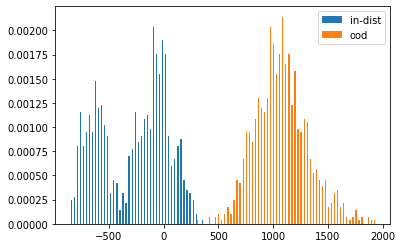

In [ ]:
#collapse-output
plt.hist([in_dist_rmaha_distances, ood_rmaha_distances], bins=100, density=True,
         label=["in-dist", "ood"])
plt.legend()
plt.show()